In [1]:
# import dependencies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Read in CSV data set with Pandas 
full_data = pd.read_csv('data/all_breakdown.csv')

# fill in na values with 0 
full_data['SOLAR'] = full_data['SOLAR'].fillna(0)
full_data['SOLAR PV'] = full_data['SOLAR PV'].fillna(0)
full_data['SOLAR THERMAL'] = full_data['SOLAR THERMAL'].fillna(0)


# Create a combined columm now that there are no nulls
full_data['SOLAR TOTAL'] = full_data['SOLAR']+full_data['SOLAR PV']+full_data['SOLAR THERMAL']



# Convert timestamp column to pandas datetime data type
full_data['TIMESTAMP'] = pd.to_datetime(full_data['TIMESTAMP'])
full_data['TIMESTAMP'] = pd.to_datetime(full_data['TIMESTAMP'])


# Allows us to acces the "dt" property of column and included methods
full_data['MONTH'] = full_data['TIMESTAMP'].dt.month
full_data['YEAR'] = full_data['TIMESTAMP'].dt.year
full_data['DAY'] = full_data['TIMESTAMP'].dt.day
full_data['HOUR'] = full_data['TIMESTAMP'].dt.hour





full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67584 entries, 0 to 67583
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TIMESTAMP      67584 non-null  datetime64[ns]
 1   BIOGAS         67584 non-null  float64       
 2   BIOMASS        67584 non-null  float64       
 3   GEOTHERMAL     67584 non-null  float64       
 4   Hour           67584 non-null  float64       
 5   SMALL HYDRO    67584 non-null  float64       
 6   SOLAR          67584 non-null  float64       
 7   SOLAR PV       67584 non-null  float64       
 8   SOLAR THERMAL  67584 non-null  float64       
 9   WIND TOTAL     67584 non-null  float64       
 10  SOLAR TOTAL    67584 non-null  float64       
 11  MONTH          67584 non-null  int64         
 12  YEAR           67584 non-null  int64         
 13  DAY            67584 non-null  int64         
 14  HOUR           67584 non-null  int64         
dtypes: datetime64[ns](1

In [2]:
from fbprophet import Prophet 

In [3]:
# create the dataframe for fb prophet, it expects specific input dataframe
model_data = pd.DataFrame(full_data.loc[full_data.TIMESTAMP.dt.year > 2013,['TIMESTAMP', 'SOLAR TOTAL']])

model_data.columns = ['ds','y']
model_data.sort_values('ds', inplace=True)
# display is jupyter built in method for showing dataframes nicely 
display(model_data.head())

train = model_data.loc[model_data.ds.dt.year < 2017,:]
test = model_data.loc[model_data.ds.dt.year >= 2017, :]

,ds,y
17040,2014-01-01 00:00:00,0.0
17041,2014-01-01 01:00:00,0.0
17042,2014-01-01 02:00:00,0.0
17043,2014-01-01 03:00:00,0.0
17044,2014-01-01 04:00:00,0.0


In [95]:
# fit a default parameter model to the data
model = Prophet()
model.fit(train)

In [96]:
future = model.make_future_dataframe(periods=365*24, freq='1H')
forecast = model.predict(future)

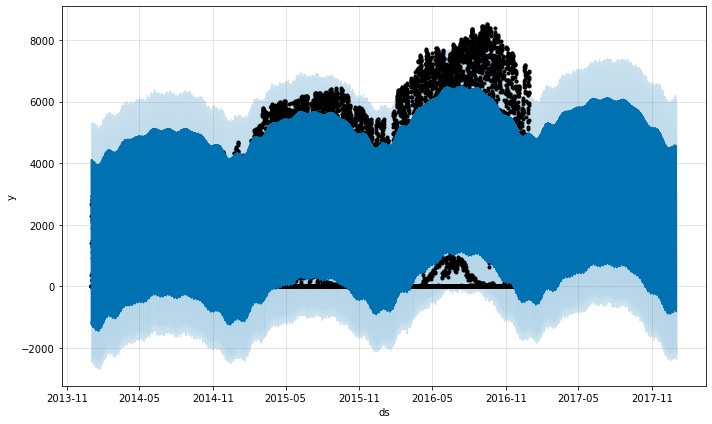

In [97]:
model.plot(forecast)
plt.savefig("Charts/firstModel.png", bbox_inches='tight')
plt.show()

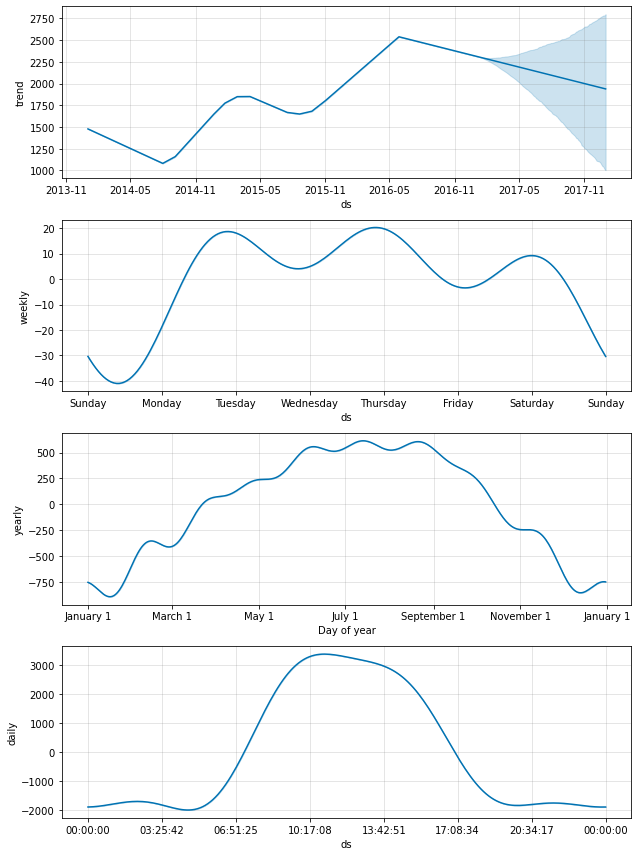

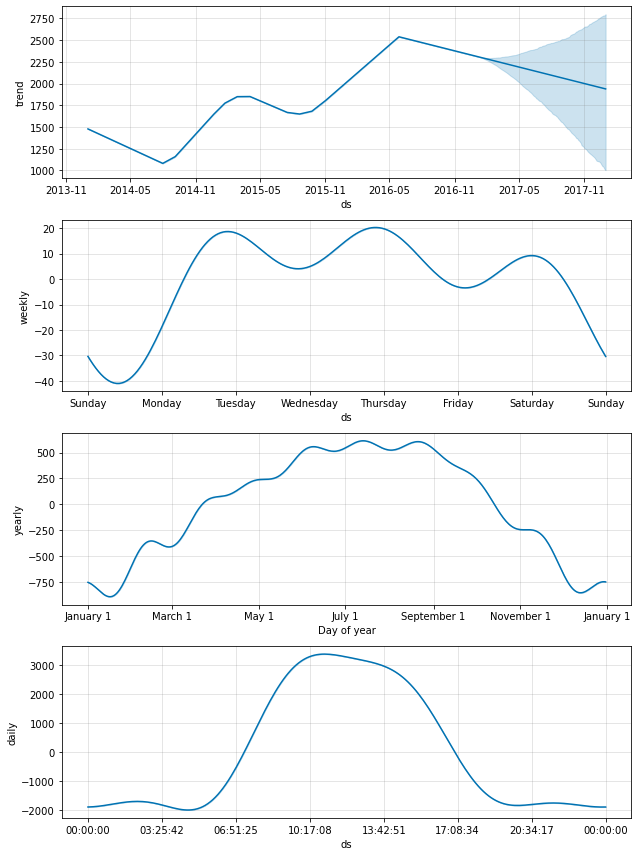

In [55]:
model.plot_components(forecast)

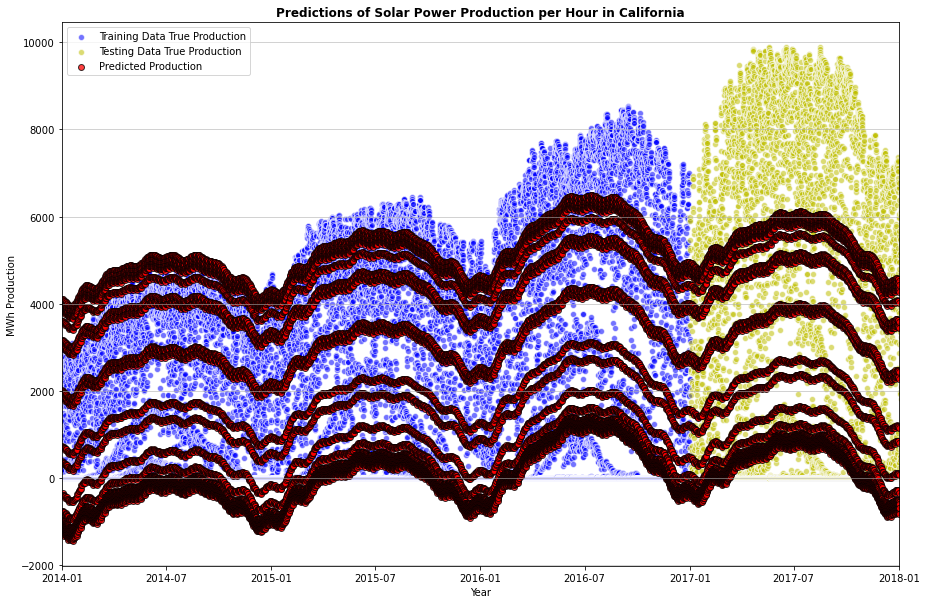

In [63]:
# look at it in a differnt way 
plt.figure(figsize=(15,10))

plt.scatter(train['ds'],train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(test['ds'],test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forecast['ds'],forecast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('2014-01-01'),pd.to_datetime('2018-01-01'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Solar Power Production per Hour in California",fontweight='bold')
plt.savefig("Charts/firstPredictions.png", bbox_inches='tight')
plt.show()

In [4]:
# now lets tune some stuff!


def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))


# create our own daily seasonality
model_data['on_season'] = model_data['ds'].apply(on_season)
model_data['off_season'] = ~model_data['ds'].apply(on_season) # ~ means opposite
model_data['cap'] = 11000 # for logistic growth 



model_data.y = np.cbrt(model_data.y)
model_data.cap = np.cbrt(model_data.cap)
display(model_data.head())


train = model_data.loc[model_data.ds.dt.year < 2017,:]
test = model_data.loc[model_data.ds.dt.year >= 2017, :]

,ds,y,on_season,off_season,cap
17040,2014-01-01 00:00:00,0.0,False,True,22.239801
17041,2014-01-01 01:00:00,0.0,False,True,22.239801
17042,2014-01-01 02:00:00,0.0,False,True,22.239801
17043,2014-01-01 03:00:00,0.0,False,True,22.239801
17044,2014-01-01 04:00:00,0.0,False,True,22.239801


In [5]:
model = Prophet(changepoint_range=.8,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=.01,seasonality_prior_scale=20)

model.add_seasonality(name='on_season_daily', period=1, condition_name='on_season', fourier_order=6)
model.add_seasonality(name='off_season_daily', period=1, condition_name='off_season', fourier_order=6)

model.fit(train)

In [6]:
future = model.make_future_dataframe(periods=365*24, freq='H')

future['on_season'] = future['ds'].apply(on_season)
future['off_season'] = ~future['ds'].apply(on_season)
future['cap'] = 15000
future.cap = np.cbrt(future.cap)

forecast = model.predict(future)

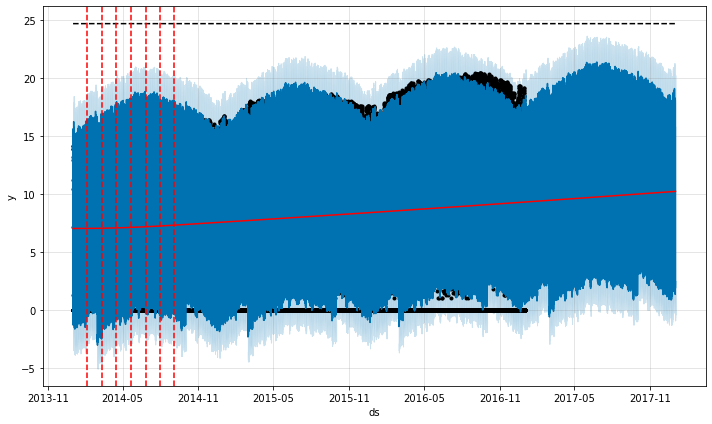

In [7]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.savefig("Charts/secondModel.png", bbox_inches='tight')
plt.show()


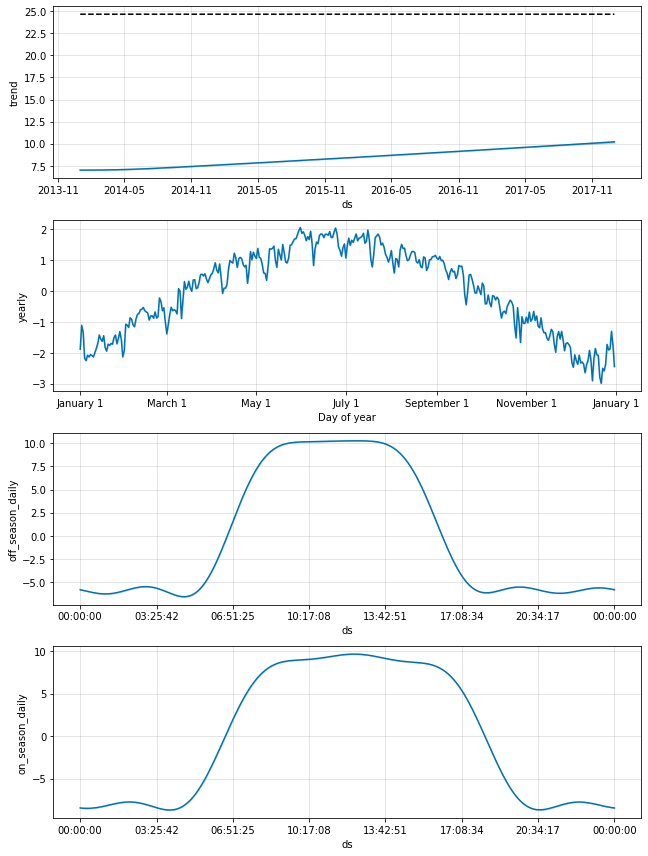

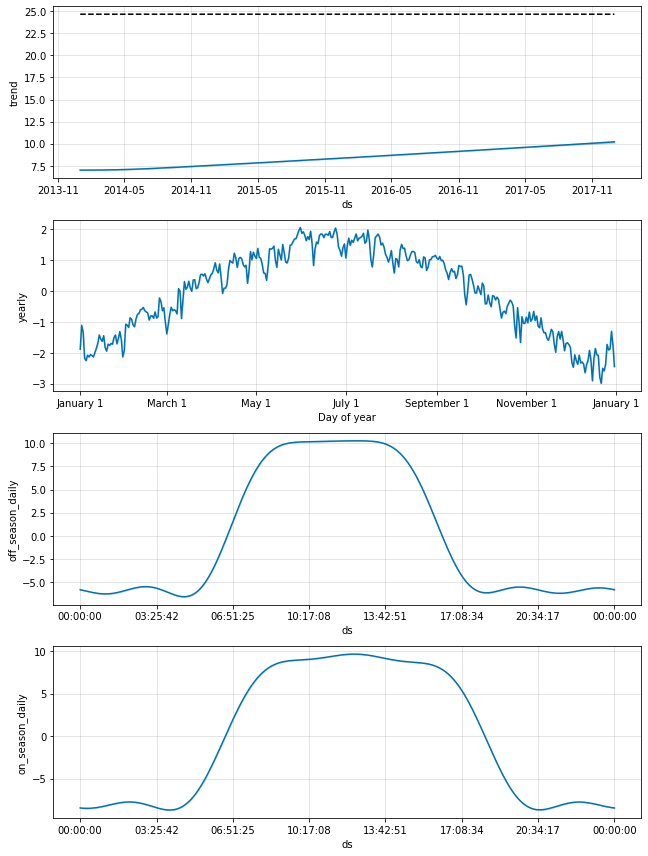

In [8]:
model.plot_components(forecast)

In [9]:
import warnings 
warnings.filterwarnings("ignore")

train.y = train.y**3
test.y = test.y**3
forecast.yhat = forecast.yhat**3

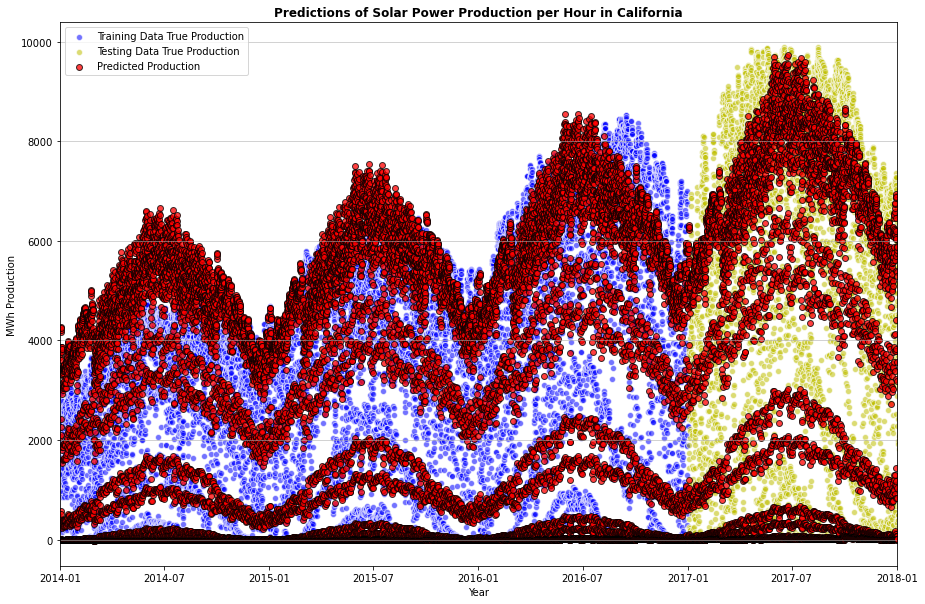

In [10]:
# look at it in a differnt way 
plt.figure(figsize=(15,10))

plt.scatter(train['ds'],train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(test['ds'],test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forecast['ds'],forecast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('2014-01-01'),pd.to_datetime('2018-01-01'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Solar Power Production per Hour in California",fontweight='bold')
plt.savefig("Charts/second_prediction.png", bbox_inches='tight')
plt.show()

In [11]:
#lets get some accuracy statistics
from sklearn.metrics import r2_score, mean_absolute_error

forecastTrain = forecast.loc[forecast.ds.dt.year < 2017,:]
forecastTest = forecast.loc[forecast.ds.dt.year >= 2017,:]

# we're missing about 30 days worth of data in test data set (true data for 2017)
# so we're going to join the tables together, and fill the NA's with 0's so we can make a calculation for accuracy
forecastTest.set_index(pd.DatetimeIndex(forecastTest.ds), inplace=True)
test = test.loc[test.ds.dt.year == 2017,:]
test.set_index(pd.DatetimeIndex(test.ds), inplace=True)


testDf = forecastTest.merge(test, how='outer', right_index=True, left_index=True)
testDf.y = testDf.y.fillna(0)
testDf.yhat = testDf.yhat.fillna(0)


print("Train R2 Score: ", r2_score(train.y, forecastTrain.yhat))
print("Train MAE: ", mean_absolute_error(train.y, forecastTrain.yhat))


print("Test R2 Score: ", r2_score(testDf.y, testDf.yhat))
print("Test MAE: ", mean_absolute_error(testDf.y, testDf.yhat))


Train R2 Score:  0.9047912458780245
Train MAE:  403.46971777595434
Test R2 Score:  0.9231201173047913
Test MAE:  552.3698339274179


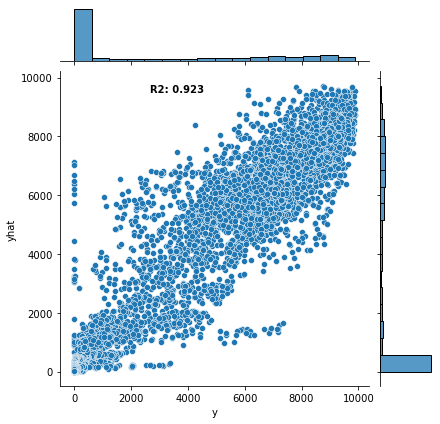

In [12]:
import seaborn as sns
sns.jointplot(x=testDf.y, y=testDf.yhat)
plt.text(-21000,9500,s='R2: {}'.format(round(r2_score(testDf.y, testDf.yhat),3)), fontweight='bold')
plt.savefig('Charts/r2Plot.png', bbox_inches='tight')
plt.show()

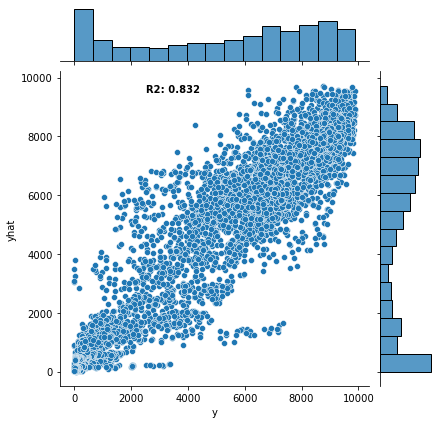

In [13]:
testDf = testDf.loc[testDf.y != 0]
sns.jointplot(x=testDf.y, y=testDf.yhat)
plt.text(-3000,9500,s='R2: {}'.format(round(r2_score(testDf.y, testDf.yhat),3)), fontweight='bold')
plt.savefig('Charts/r2Plot_no_0.png', bbox_inches='tight')
plt.show()

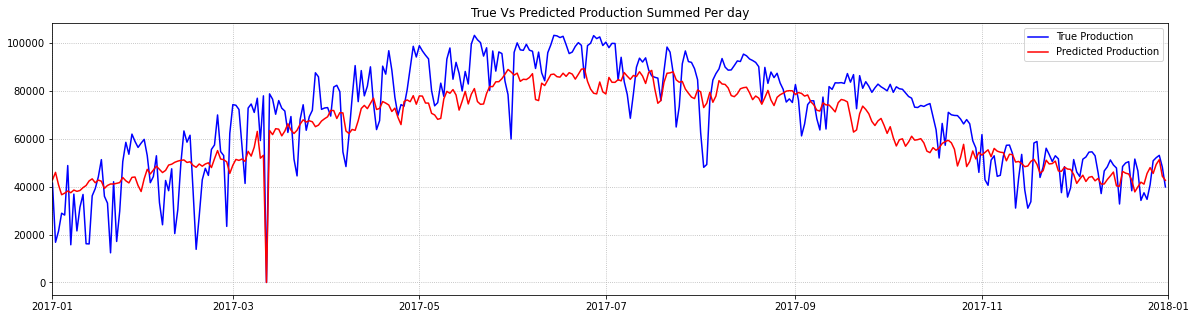

Predicted total 2017 Solar : 23405.6 GWh
True total 2017 Solar :  25270.25 GWh
Total Year % Error :  7.38 %


In [14]:
# lets group the data a bit to get a better feel for the accuracy of this version
plot = testDf[['y','yhat']]

plot = plot.resample('24H').sum()

plt.figure(figsize=(20,5))
plt.plot(plot.index, plot.y, label="True Production", color='b')
plt.plot(plot.index, plot.yhat, label="Predicted Production", color='r', linestyle='-')
plt.legend()
plt.title("True Vs Predicted Production Summed Per day")
plt.grid(linestyle=":")
plt.xlim(pd.to_datetime('2017-01-01'),pd.to_datetime('2018-01-01'))
plt.savefig("Charts/finalPrediction.png", bbox_inches='tight')
plt.show()


print("Predicted total 2017 Solar :", round(plot.yhat.sum() / 1000,2), "GWh")
print("True total 2017 Solar : ", round(plot.y.sum() / 1000,2), "GWh")
print("Total Year % Error : ", round(((np.abs(plot.yhat.sum() - plot.y.sum()))/ plot.y.sum()) * 100,2), "%")

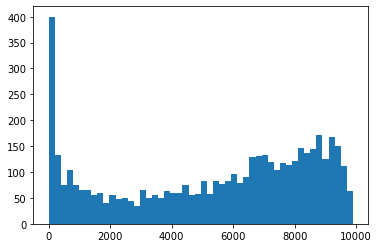

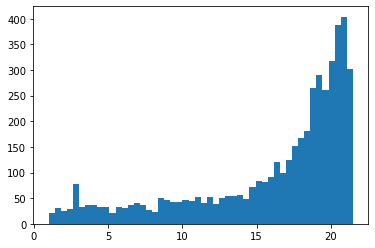

In [24]:
#here's why I cbrt transform the y data, the first data seemed to get hung up on all the 0's.
#want the production to shine rather than the lack of production
plt.hist(testDf.y, bins=50)
plt.show()
plt.hist(np.cbrt(testDf.y), bins=50)
plt.show()